<a href="https://colab.research.google.com/github/RGithub23/numpy_depth_showcase/blob/main/numpy_depth_showcase.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NumPy Depth Showcase (MiDaS Style)

This Google Colab notebook a method to mimic a MiDaS-style depth-from-image demo without machine learning, using transparent NumPy steps. It involves loading and normalizing an image, computing feature maps, generating a heuristic depth blend, regularizing, computing gradients, and converting the depth map into coordinate grids for 3D visualization.

Workflow:  MiDaS-style load → depth → visualize.

What you will see:
- Vectorized grayscale conversion and normalization
- Sobel edge magnitude via 2D convolution with numpy.lib.stride_tricks.sliding_window_view
- Gaussian blur implemented in pure NumPy
- A simple heuristic "depth" map blended from inverted luminance, edges, and a radial prior
- Surface normals from np.gradient
- A simple pinhole projection to 3D point-cloud arrays (X, Y, Z)

This mirrors the flow of MiDaS depth demos but replaces the neural network with transparent NumPy steps for teaching and experimentation.

## Instructions (Colab or local)
1. Set IMG_PATH to your image path. In Colab, upload an image to /content/ or use the upload cell below.
2. Run the cells top-to-bottom.
3. The notebook will display the intermediate results and print array shapes.

Dependencies: NumPy, Matplotlib, Pillow (install with `pip install pillow` if missing).

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path

IMG_PATH = "/content/Apple.png"  # Change this to your image path
GAUSS_SIGMA = 2.0                   # Blur strength for depth smoothing
DEPTH_NEAR_FAR = (1.0, 8.0)         # Range for Z when making a point cloud

print("Configured IMG_PATH:", IMG_PATH)

Configured IMG_PATH: /content/Apple.png


This Code Block

* Imports core libs: NumPy for array math, Matplotlib for plotting, PIL for image
   
* IO, Path for file paths.

* Sets three configuration constants:

* IMG_PATH: where to load the input image from.

* GAUSS_SIGMA: the standard deviation for a Gaussian blur (used later to smooth the depth).

* DEPTH_NEAR_FAR: the near/far clipping range for a simple point-cloud projection.

* Prints the active image path to confirm config.

In [2]:
try:
    from google.colab import files  # type: ignore
    print("Use the dialog to upload an image file.")
    up = files.upload()
    if len(up):
        fname = list(up.keys())[0]
        IMG_PATH = f"/content/{fname}"
        print("IMG_PATH set to:", IMG_PATH)
except Exception:
    print("Colab upload cell: not in Colab or upload skipped.")

Use the dialog to upload an image file.


Saving Apple2.PNG to Apple2.PNG
IMG_PATH set to: /content/Apple2.PNG


This code block

* Detects if you’re in Google Colab.

* Defines load_image_to_np that opens an image, converts to RGB, and normalizes pixel values to [0,1].

* Defines a small show_image helper to display arrays (2D with a colormap or 3D RGB).

* Prints a tip depending on Colab vs local execution.

In [3]:
from numpy.lib.stride_tricks import sliding_window_view

def load_image(path, max_side=1024):
    path = Path(path)
    img = Image.open(path).convert("RGB")
    w, h = img.size
    scale = min(1.0, max_side / max(w, h))
    if scale < 1.0:
        img = img.resize((int(w*scale), int(h*scale)), Image.LANCZOS)
    arr = np.asarray(img).astype(np.float32) / 255.0
    return arr

def to_gray(rgb):
    w = np.array([0.2989, 0.5870, 0.1140], dtype=np.float32)
    return np.tensordot(rgb, w, axes=([-1], [0]))

def minmax(x, eps=1e-8):
    x = np.asarray(x, dtype=np.float32)
    mn, mx = np.nanmin(x), np.nanmax(x)
    return (x - mn) / (mx - mn + eps)

def sliding_window_conv2(img, kernel):
    img = np.asarray(img, dtype=np.float32)
    k = np.asarray(kernel, dtype=np.float32)
    kh, kw = k.shape
    ph, pw = kh // 2, kw // 2
    padded = np.pad(img, ((ph, ph), (pw, pw)), mode='edge')
    windows = sliding_window_view(padded, (kh, kw))
    out = (windows * k[None, None, :, :]).sum(axis=(-1, -2))
    return out

def sobel_edges(gray):
    Kx = np.array([[1, 0,-1],
                   [2, 0,-2],
                   [1, 0,-1]], dtype=np.float32)
    Ky = Kx.T
    gx = sliding_window_conv2(gray, Kx)
    gy = sliding_window_conv2(gray, Ky)
    mag = np.hypot(gx, gy)
    return minmax(mag)

def gaussian_kernel2d(sigma, radius=None):
    if radius is None:
        radius = max(1, int(np.ceil(3*sigma)))
    ax = np.arange(-radius, radius+1, dtype=np.float32)
    g1 = np.exp(-(ax**2)/(2*sigma*sigma))
    g1 /= g1.sum()
    g2 = np.outer(g1, g1)
    g2 /= g2.sum()
    return g2

def gaussian_blur(img, sigma):
    k = gaussian_kernel2d(sigma)
    return sliding_window_conv2(img, k)

def radial_mask(h, w):
    yy, xx = np.mgrid[0:h, 0:w]
    cx, cy = (w-1)/2.0, (h-1)/2.0
    r = np.sqrt((xx - cx)**2 + (yy - cy)**2)
    return 1.0 - minmax(r)

def make_numpy_depth(rgb):
    gray = to_gray(rgb)
    inv_gray = 1.0 - minmax(gray)
    edges = sobel_edges(gray)
    rad = radial_mask(*gray.shape)
    depth = 0.6*inv_gray + 0.3*edges + 0.1*rad
    depth = minmax(depth)
    depth = gaussian_blur(depth, GAUSS_SIGMA)
    depth = minmax(depth)
    return depth, {"gray": gray, "inv_gray": inv_gray, "edges": edges, "radial": rad}

def depth_to_normals(depth):
    dy, dx = np.gradient(depth.astype(np.float32))
    nx, ny = -dx, -dy
    nz = np.ones_like(depth, dtype=np.float32)
    n = np.stack([nx, ny, nz], axis=-1)
    n /= (np.linalg.norm(n, axis=-1, keepdims=True) + 1e-8)
    n_disp = (n + 1.0) * 0.5
    return n, n_disp

def depth_to_pointcloud(depth, near_far=(1.0, 8.0)):
    h, w = depth.shape
    z = near_far[0] + depth * (near_far[1] - near_far[0])
    yy, xx = np.mgrid[0:h, 0:w]
    fx = fy = max(h, w) * 1.2
    cx, cy = (w-1)/2.0, (h-1)/2.0
    X = (xx - cx) * z / fx
    Y = (yy - cy) * z / fy
    Z = z
    return X, Y, Z

def show_image(img, title=None, cmap=None):
    plt.figure()
    if cmap is None:
        plt.imshow(img)
    else:
        plt.imshow(img, cmap=cmap)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

This code block

* rgb_to_grayscale: converts RGB to luminance via weighted sum.

* Implements a pure NumPy Gaussian blur as a separable 1D convolution using sliding_window_view and reflect padding.

* sobel_edges: computes Sobel gradients and an edge magnitude map normalized to [0,1].

* radial_mask: produces a center-bright mask that fades toward corners (a simple “depth prior”).

In [4]:
rgb = load_image(IMG_PATH)
depth, parts = make_numpy_depth(rgb)
normals, normals_disp = depth_to_normals(depth)
X, Y, Z = depth_to_pointcloud(depth, DEPTH_NEAR_FAR)
print("Pipeline complete.")

Pipeline complete.


This code Block

* Loads your image.

* Builds intermediate maps: grayscale luminance, Sobel edge magnitude, and a radial prior.

* Creates a heuristic depth by blending inverted luminance, edges, and radial prior (no ML).

* Smooths with Gaussian blur and normalizes to [0,1].

* Uses np.gradient on the depth map to estimate surface normals and prepares a displayable RGB normal map.

* Converts the 2D depth map into simple camera-space arrays (X, Y, Z) using a pinhole-style relationship with a chosen focal length and the configured near/far range.

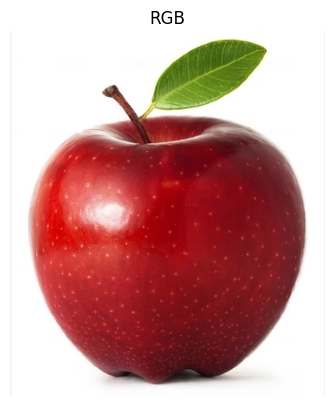

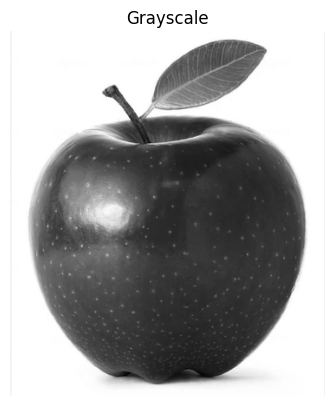

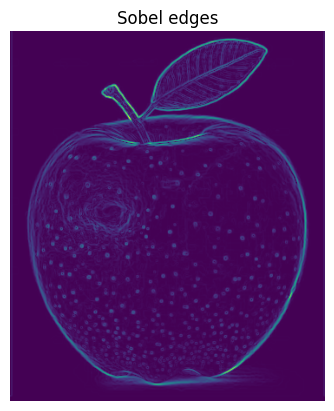

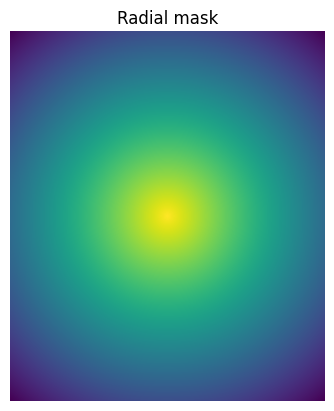

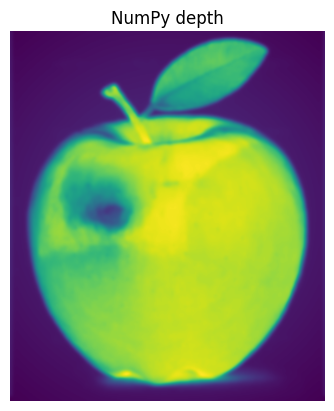

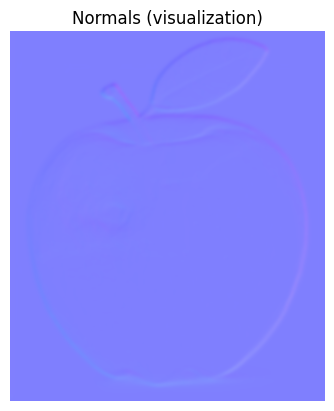

In [5]:
show_image(rgb, title="RGB")
show_image(parts['gray'], title="Grayscale", cmap='gray')
show_image(parts['edges'], title="Sobel edges")
show_image(parts['radial'], title="Radial mask")
show_image(depth, title="NumPy depth")
show_image(normals_disp, title="Normals (visualization)")

This code block

* Prints array shapes for sanity-checking the pipeline outputs.

In [6]:
print("RGB:", rgb.shape)
print("Depth:", depth.shape)
print("Normals:", normals.shape)
print("X, Y, Z:", X.shape, Y.shape, Z.shape)

RGB: (426, 363, 3)
Depth: (426, 363)
Normals: (426, 363, 3)
X, Y, Z: (426, 363) (426, 363) (426, 363)


What’s happening in the workflow (big picture)

Goal: mimic a MiDaS-style depth-from-image demo without machine learning—using only transparent NumPy steps for teaching/experimentation.

Flow:

Load & normalize the image to [0,1].

Feature maps: compute grayscale luminance, Sobel edges, and a radial prior (center nearer).

Heuristic depth blend: depth_raw = 0.55*(1 - gray) + 0.30*edges + 0.15*radial.

Regularize: apply a Gaussian blur and normalize to [0,1].

Normals: compute gradients of depth and convert to a unit normal map (handy for shading/inspection).

Point cloud scaffolding: convert the depth map into (X, Y, Z) coordinate grids with a simple pinhole formula, ready for downstream 3D visualization (e.g., plotting or exporting).

Why this is useful: it shows the shape of a typical depth-estimation pipeline (preprocess → depth → postprocess → geometry) in a way you can fully read, tweak, and reason about—no black-box networks required. You can swap weights, kernels, priors, or projection parameters and immediately see the effect.